In [1]:
# Uncomment the commented-out lines in this cell when generating ELMo embeddings to avoid excess warning messages.
import gc
import glob
import functools
import operator
import itertools
from sacremoses import MosesTokenizer  # For ELMo preprocessing
import matplotlib.pyplot as plt
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# tf.get_logger().setLevel('ERROR')
# tf.logging.set_verbosity(tf.logging.ERROR)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow_hub as hub
from sklearn.linear_model import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.decomposition import *
from Models import *

In [2]:
fs = glob.glob(data_dir + wiki_dir + "*.jsonl")
elmo_tokenizer = MosesTokenizer()  # Tokenise in the same way as ELMo's original training
transl_elmo = lambda s: ' '.join(elmo_tokenizer.tokenize(s, escape=False)).replace(" ' s ", " 's ")

In [3]:
transl_elmo("From 1985―2015 Coster-Waldau"), transl_elmo("From 1985-2015 Coster-Waldau")  # Leaves the dashes alone

('From 1985 ― 2015 Coster-Waldau', 'From 1985-2015 Coster-Waldau')

In [24]:
def load_claims(n=10, offs=0, test=True, dev=False, verifiable_only=True):
    claims = []
    claims_vocab = set()
    i_ = 0
    with open(data_dir + ("shared_task_dev" if dev else "train") + ".jsonl", 'r') as f:
        for a_ in jsonlines.Reader(f):
            if dev or ((a_["id"] in test_claim_ids) ^ (not test)):
                if verifiable_only and a_["verifiable"] != "VERIFIABLE": continue
                i_ += 1
                if i_ <= offs: continue
#                 if a_["verifiable"] == "VERIFIABLE":
#                     for j in range(len(a_["evidence"])):
#                         for k in range(len(a_["evidence"][j])):
#                             a_["evidence"][j][k][2] = unicodedata.normalize('NFC', a_["evidence"][j][k][2])
                claims.append(a_)
                claims[-1]["vocab"] = defaultdict(int)
                for w in rem_punct(a_["claim"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '')).split():
                    claims[-1]["vocab"][w] += 1
                    claims_vocab.add(w)
            if i_ == n + offs: break
    return claims, claims_vocab

In [25]:
claims, claims_vocab = load_claims(n=1000, test=False, verifiable_only=False)  # Load 1000 training claims
N_claims = len(claims)
N_claims

1000

In [4]:
claims, claims_vocab = load_claims(n=1000, test=False)  # Load 1000 training claims
claims_dev, claims_vocab_dev = load_claims(dev=True)
claims += claims_dev
claims_vocab |= claims_vocab_dev
N_claims = len(claims)
print(N_claims, len(claims_vocab), [c["id"] for c in claims[-10:]])

1010 3119 [137334, 111897, 89891, 181634, 219028, 108281, 204361, 54168, 105095, 18708]


In [ ]:
# Load documents as term frequencies and total word counts
tfs, wiki, n_t = load_docs(fs, claims_vocab, load_tf=True)

In [20]:
save_ld((tfs, wiki, n_t), "loaded_docs_1000c+d")

In [5]:
tfs, wiki, n_t = load_ld("loaded_docs_1000c+d")

In [21]:
D_ids = list(wiki.keys())
tdist = sorted([(a, b) for (b, a) in list(tfs.items())])[::-1]      # Term freqeuency distribution
y = [t[0] for t in tdist]
N_docs = len(wiki)                                                  # Number of documents
N = len(y)                                                          # Number of unique terms
mean_doc_len = np.mean([wiki[id_][1] for id_ in wiki])
words_total = sum(tfs.values())
c_M = {w: tfs[w] / words_total for w in tfs}
N_docs, N, mean_doc_len, words_total, c_M["the"], c_M["of"]

(5396101,
 5174471,
 117.62701346768714,
 634727245,
 0.0421404882344384,
 0.03353797267675188)

In [22]:
# Adjust variables to implement smooth IDF and smoothed Jelinik-Mercer/Dirichlet smoothing (assume that words found only in
# the query claim, and not in the wikipedia pages, occur once in the wikipedia pages, in one existing new document)
changed = False
for w in claims_vocab:
    if w not in n_t:
        n_t[w] = 0
        tfs[w] = 1
        N += 1
        changed = True
if changed:
    words_total = sum(tfs.values())
    c_M = {w: tfs[w] / words_total for w in tfs}

In [8]:
cbi = 9
claims, claims_vocab = load_claims(n=100, offs=cbi * 100, test=False)     # Load training claims batch
for d_id in wiki:
    wiki[d_id] = ({w: wiki[d_id][0][w] for w in claims_vocab if w in wiki[d_id][0]}, wiki[d_id][1])     # Use memory efficiently
N_claims = len(claims)
gc.collect(), N_claims

(0, 100)

In [33]:
# Define document models
def lidstone_ll(doc_tf, total, epsilon=0.05, claims_=[]):
    zero_count_prob = epsilon / (total + (epsilon * N))
    doc_M = {w: ( (doc_tf[w] + epsilon) / (total + (epsilon * N)) ) for w in doc_tf if doc_tf[w] >= 1}
    return [np.sum(np.log([doc_M[w] if w in doc_M else zero_count_prob for w in claim["vocab"]])) for claim in claims_]
def dirichlet_ll(doc_tf, total, mu=mean_doc_len * 30.0, claims_=[]):
    doc_M_weight = (total / (total + mu))
    c_M_weight   = (mu    / (total + mu))
    doc_M = {w: ( (doc_M_weight * (doc_tf[w] if w in doc_tf else 0) / total) + \
                    (c_M_weight * c_M[w]) ) for w in claims_vocab}
    return [np.sum(np.log([doc_M[w] for w in claim["vocab"]])) for claim in claims_]
def eval_model(sim_func, **ps):
    batch_size = 10000
    D_batches = [D_ids[i * batch_size:(i + 1) * batch_size] for i in range((N_docs // batch_size) + 1)]
    print("Computing similarities (" + str(len(D_ids)) + " in " + str(len(D_batches)) + " batches)...")
    similarities = sum(joblib.Parallel(n_jobs=n_cpu, verbose=5)(delayed(batch_sims)(
        [wiki[doc_id] for doc_id in D_batch], sim_func, **ps) for D_batch in D_batches), [])
    sys_print("Ranking documents...")
    top_docs = []
    for i in range(N_claims):
        sims = np.asarray([similarities[j][i] for j in range(N_docs)])
        ord_ = np.argsort(sims)
        top_docs.append([D_ids[j] for j in ord_[-1000:]])
        sys_print("\rRanking documents... " + str(i + 1) + '/' + str(N_claims) + ' ')
    print("Evaluating accuracy...")
    res = eval_acc(top_docs, claims)
    return res, top_docs

In [10]:
accs, top_docs = eval_model(dirichlet_ll, claims_=claims)  # Get documents using Dirichlet retrieval
pr(accs)
save_json((accs, top_docs), "topdocs_dirichlet_ll_100c_" + str(cbi) + ".json", pad=False)

Computing similarities (5396101 in 540 batches)...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   54.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 10.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 19.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 30.9min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed: 38.6min finished


Ranking documents... 100/100 Evaluating accuracy...
 Scoring evidence retrieval...
0.65 0.6666666666666665 0.6738095238095239 0.6711711711711712 0.14799999999999996 0.1333333333333333 0.13476190476190475 0.298 0.24110275689223049 0.22222222222222218 0.2246031746031746 0.4127423822714681
(   0.65,
    0.6666666666666665,
    0.6738095238095239,
    0.6711711711711712,
    0.14799999999999996,
    0.1333333333333333,
    0.13476190476190475,
    0.298,
    0.24110275689223049,
    0.22222222222222218,
    0.2246031746031746,
    0.4127423822714681)


In [14]:
# Assemble batched results
top_docs = []
for i in range(10):
    _, tds = load_json("topdocs_dirichlet_ll_100c_" + str(i) + ".json", pad=False)
    top_docs += tds
claims, claims_vocab = load_claims(n=1000, offs=0, test=False)  # Load 1000 training claims
N_claims = len(claims)
eval_acc(top_docs, claims)
len(top_docs)

 Scoring evidence retrieval...
0.557 0.5744023809523809 0.45022395607571153 0.4260869565217391 0.1286 0.11488047619047619 0.0900447912151423 0.2254 0.20895624270711782 0.1914674603174603 0.15007465202523718 0.29483322432962716


1000

In [15]:
k_scores = np.asarray([list(eval_acc(top_docs, claims, n=n, verbose=False)) for n in range(1, 50)])

<Figure size 432x288 with 0 Axes>

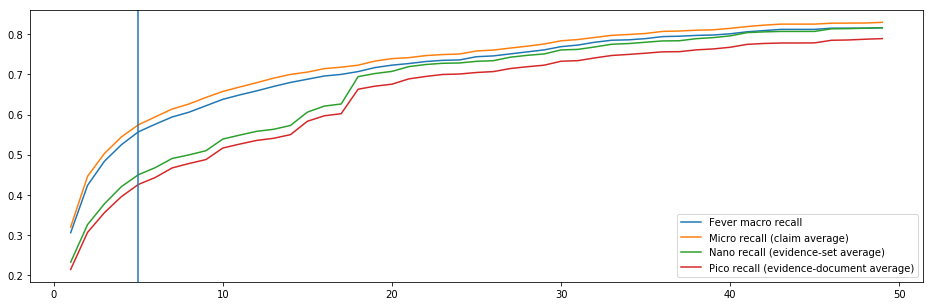

In [16]:
plt.clf()
fig = plt.figure()
fig.set_size_inches(16, 5)
plt.plot(range(1, 50), k_scores[:, 0], label="Fever macro recall")
plt.plot(range(1, 50), k_scores[:, 1], label="Micro recall (claim average)")
plt.plot(range(1, 50), k_scores[:, 2], label="Nano recall (evidence-set average)")
plt.plot(range(1, 50), k_scores[:, 3], label="Pico recall (evidence-document average)")
plt.axvline(x=5)
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

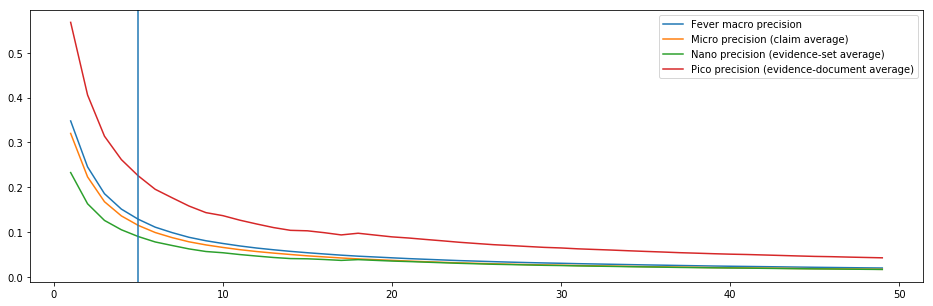

In [17]:
plt.clf()
fig = plt.figure()
fig.set_size_inches(16, 5)
plt.plot(range(1, 50), k_scores[:, 4 + 0], label="Fever macro precision")
plt.plot(range(1, 50), k_scores[:, 4 + 1], label="Micro precision (claim average)")
plt.plot(range(1, 50), k_scores[:, 4 + 2], label="Nano precision (evidence-set average)")
plt.plot(range(1, 50), k_scores[:, 4 + 3], label="Pico precision (evidence-document average)")
plt.axvline(x=5)
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

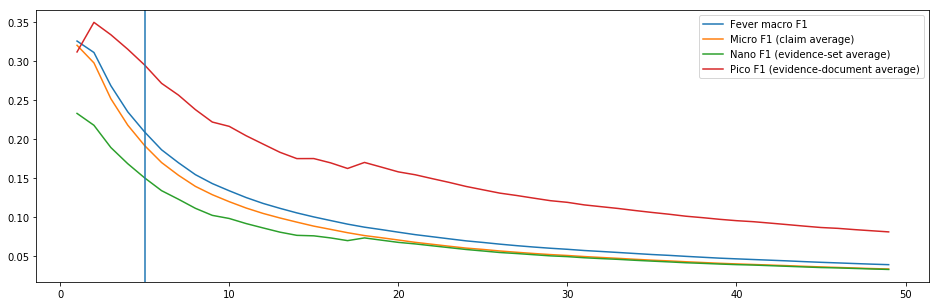

In [18]:
plt.clf()
fig = plt.figure()
fig.set_size_inches(16, 5)
plt.plot(range(1, 50), k_scores[:, 8 + 0], label="Fever macro F1")
plt.plot(range(1, 50), k_scores[:, 8 + 1], label="Micro F1 (claim average)")
plt.plot(range(1, 50), k_scores[:, 8 + 2], label="Nano F1 (evidence-set average)")
plt.plot(range(1, 50), k_scores[:, 8 + 3], label="Pico F1 (evidence-document average)")
plt.axvline(x=5)
plt.legend()
plt.show()

In [19]:
# Free memory of variables no longer needed
del wiki, tfs, D_ids, tdist, y

In [27]:
# save_json(top_docs, "topdocs_dirichlet_1000c.json", pad=False)
top_docs = load_json("topdocs_dirichlet_1000c.json", pad=False)
len(top_docs), len(claims)

(1000, 1010)

In [32]:
claims, claims_vocab = load_claims(dev=True)  # Load development set claims for Q4 (after this cell redefine likelihood models)
N_claims = len(claims)

In [73]:
accs_dev, top_docs_dev = eval_model(dirichlet_ll, claims_=claims)  # Retrieve test set documents
save_json((accs_dev, top_docs_dev), "topdocs_dirichlet_ll_10dev.json", pad=False)
len(top_docs_dev)

Computing similarities (5396101 in 540 batches)...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   30.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 10.0min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed: 12.2min finished


Ranking documents... 10/10 Evaluating accuracy...
 Scoring evidence retrieval...
0.4 0.4 0.43478260869565216 0.44 0.1 0.08 0.08695652173913043 0.22 0.16 0.13333333333333333 0.14492753623188406 0.29333333333333333


10

In [ ]:
top_docs += top_docs_dev

In [225]:
claims, claims_vocab = load_claims(n=1000, test=False)  # Load 1000 training claims
claims_dev, claims_vocab_dev = load_claims(dev=True)
claims += claims_dev
claims_vocab |= claims_vocab_dev
N_claims = len(claims)
N_claims, len(top_docs)

(1010, 1010)

In [146]:
# save_json(top_docs, "topdocs_dirichlet_1010c+d.json", pad=False)
top_docs = load_json("topdocs_dirichlet_1010c+d.json", pad=False)
len(top_docs), len(claims)

(1010, 1010)

In [5]:
top = load_json("topdocs_lidstone_1000c.json", pad=False)

In [7]:
top['docs'][0]

[[-70.94364562270744, 'Leadership_review'],
 [-70.50573000303399, 'National_Liberal_Party_-LRB-Romania,_1875-RRB-'],
 [-69.52077184086515, 'Timeline_of_the_University_of_Wisconsin–Parkside'],
 [-66.2736263298278, 'System_of_a_Down'],
 [-65.5740941752419, 'Delorimier_Stadium']]

In [20]:
top_docs = [[s[1] for s in s_] for s_ in top['docs']]
print("Re-evaluating accuracy...")
recall = np.mean([np.mean([
    id_ in top_docs[i] for id_ in set([s[2] for s in sum(claims[i]["evidence"], [])])]) \
                 for i in range(len(claims))])
recall

Re-evaluating accuracy...


0.36417063492063495

In [6]:
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

# just a random sentence 
x = ["The quick brown fox",
     "The quick brown fox jumped",
     "The quick brown fox jumped over",
     "Random test sentence without any relevance",
     "The quick brown fox jumped over the lazy dog",]

# Extract ELMo features 
embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
embeddings.shape

TensorShape([Dimension(5), Dimension(9), Dimension(1024)])

In [10]:
def elmo_vectors(x, key='elmo'):
    embeddings = elmo(x, signature="default", as_dict=True)[key]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        return sess.run(embeddings)
v = elmo_vectors(x, key='elmo')
w = elmo_vectors(x, key='default')
v.shape, w.shape, sum(np.mean(v[-1], axis=0) - w[-1]) # Default sentence embedding is mean-pooling of contextualised word vectors

KeyboardInterrupt: 

In [ ]:
v[-4:, 4:, 0] # An identical stop symbol is used at the end of all sentences with length lower than the max; use indexing

In [29]:
def load_docs_lines():
    i_ = 0
    wiki_ls = {}
    for fn in fs:
        with open(fn, 'r') as f:
            for a_ in jsonlines.Reader(f):
                if a_["id"] == "" or a_["lines"] == "":
                    continue
                ls = a_["lines"].replace('-LRB-', '(').replace('-RRB-', ')').split('\n')
                lines = {}
                cur_num = 0
                for l in ls:
                    if '\t' not in l:
                        if l.isnumeric():
                            continue
                        line_num = cur_num
                    else:
                        first_tab = l.index('\t')
                        line_num, l = l[:first_tab], l[first_tab + 1:]
                        if not line_num.isnumeric():
                            line_num = str(cur_num)
                    if '\t' in l:
                        l = l[:l.index('\t')]
                    if len(l.split(' ')) > 0 and not (len(l.split(' ')) == 1 and l.strip().isnumeric()):
                        l = [w for w in l.split() if w != \
                             '' and not ((any(c.isnumeric() for c in w) and len(w) > max_alphanum_len) or \
                             (w.isnumeric() and len(w) > max_number_len))]
                        if len(l) > 0:
                            cur_num = int(line_num)
                            lines[cur_num] = ' '.join(l)
                    cur_num += 1
                wiki_ls[a_['id']] = lines
        i_ += 1
        sys_print("\r" + str(i_) + " / " + str(len(fs)))
    return wiki_ls
wiki_lines = load_docs_lines()

109 / 109

In [16]:
# save_ld(wiki_lines, "loaded_wikilines")
wiki_lines = load_ld("loaded_wikilines")

In [40]:
# To reduce complexity, we ignore samples which are clearly not full, valid english sentences, using
# a rule that they must contain 3 alphabetical (non-number or punct.) words; this is because
# all_relsamples[new_is[100]] # We have many valid 3-word sentences

['Golf in Scotland', 'Scotland has 578 courses .', False, 16, 38, 9]

In [48]:
# [all_relsamples[new_is[i+ 500]] for i in range(25)] # But many invalid 2-word sentences

[['Index of philosophy of religion articles',
  'Dimitrije Mitrinović',
  False,
  199,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Dipolar theism',
  False,
  200,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Direct revelation',
  False,
  201,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Divine apathy',
  False,
  203,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Divine simplicity',
  False,
  205,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Doomsday argument',
  False,
  210,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Doomsday cult',
  False,
  211,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Doomsday event',
  False,
  212,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Eliminative materialism',
  False,
  219,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Elizabeth Burns',
  False,
  220,
  137,
  9],
 ['Index of philosophy of r

In [53]:
# Generate IDF weightings counts for sentences & documents
min_valid_words = 3
rchs = list(punct + '0123456789') + ['']
N_sents = 0
sent_n_t = defaultdict(int)
sent_tfs = defaultdict(int)
N_docs = len(wiki_lines)
doc_n_t = defaultdict(int)
i, max_i = -1, len(wiki_lines)
for a_id in wiki_lines:
    i += 1
    doc_words = set()
    for l in list(wiki_lines[a_id].values()) + [a_id.replace('_', ' ')
                    .replace('-LRB-', ' ( ').replace('-RRB-', ' ) ')]:
        ws = l.split(' ')
        ws = [w for w in ws if len(w) > 0]
        if len([w for w in ws if w[0] not in rchs]) < min_valid_words: continue
        N_sents += 1
        for w in ws:
            sent_tfs[w] += 1
        for w in set(ws):
            sent_n_t[w] += 1
            doc_words.add(w)
    for w in doc_words:
        doc_n_t[w] += 1
    if i % 1000 == 0 or i == max_i - 1:
        sys_print("\r" + str(i + 1) + '/' + str(max_i) + ' documents   (' + str(round(100 * (i + 1) / max_i)) + '%)')
print('\nTotal sentences: ' + str(N_sents))
sent_words_total = sum(sent_tfs.values())
print('Total words: ' + str(sent_words_total))
sent_c_M = {w: sent_tfs[w] / sent_words_total for w in sent_tfs}

5396106/5396106 documents   (100%)
Total sentences: 26658439
Total words: 525329655


In [13]:
# save_ld((N_docs, doc_n_t, N_sents, sent_n_t, sent_tfs, sent_words_total, sent_c_M, min_valid_words), "sentence_model")
N_docs, doc_n_t, N_sents, sent_n_t, sent_tfs, sent_words_total, sent_c_M, min_valid_words = load_ld("sentence_model")

In [62]:
# Sentence Relevance
# Create dataset: for each sentence of the top 5 documents for each of the 1000 claims,
# encode it's relevance as whether it appears in one of the evidence sentences of the claim.
import spacy
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'entity_linker', 'textcat', 'entity_ruler', 'sentencizer'])
rel_data = []
n_samples, n_relevant = 0, 0
for i in range(len(claims)):
    claim = deepcopy(claims[i])
    top5 = top_docs[i]
    if claim["verifiable"] != "VERIFIABLE": continue
    evi = claim["evidence"]
    evi = set(sum([[tuple(et_[2:]) for et_ in et] for et in evi], []))
    doc_titles = [' '.join([str(token) for token in nlp(doc.replace('_', ' ')
                    .replace('-LRB-', '(').replace('-RRB-', ')'))]) for doc in top5]
    samples = OrderedDict()
    j = -1
    for doc in top5:
        j += 1
        samples[doc] = [(doc_titles[j], wiki_lines[doc][l_num], (doc, l_num) in evi, (doc, l_num)) for l_num in wiki_lines[doc]]
    samples_list = sum(list(samples.values()), [])
    n_samples += sum([len(s) for s in samples_list])
    n_relevant += sum([x[2] for x in samples_list])
    claim["relevance_claim"] = ' '.join([str(token) for token in nlp(claim["claim"])])
    claim["relevance_documents"] = doc_titles
    claim["relevance_samples"] = samples
    rel_data.append(claim)
len(rel_data), n_samples, n_relevant / n_samples, n_relevant

(732, 662700, 0.0007620341029123284, 505)

In [61]:
# Sentence Relevance
# Create dataset: for each sentence of the top 5 documents for each of the 1000 claims,
# encode it's relevance as whether it appears in one of the evidence sentences of the claim.
rel_data, sample_lens = [], []
n_samples, n_relevant, n_rel_missed = 0, 0, 0
for i in range(len(claims)):
    claim = deepcopy(claims[i])
    top5 = top_docs[i][-5:]
    if claim["verifiable"] != "VERIFIABLE": continue
    evi = claim["evidence"]
    evi = set(sum([[tuple(et_[2:]) for et_ in et] for et in evi], []))
    doc_titles = [' '.join([w for w in doc.replace('_', ' ')
                    .replace('-LRB-', '( ').replace('-RRB-', ' )').split(' ') if w != '']) for doc in top5]
#     evi_titles = [' '.join([w for w in doc.replace('_', ' ')
#                     .replace('-LRB-', '( ').replace('-RRB-', ' )').split(' ') if w != '']) for (doc, _) in evi]
    samples = OrderedDict()
#     found_ids = []
    samples_missed = []
    j = -1
    for doc in top5:
        j += 1
        samples[doc] = [(doc_titles[j], wiki_lines[doc][l_num], (doc, l_num) in evi, (doc, l_num)) for l_num in wiki_lines[doc]]
#         found_ids += [(doc, l_num) for l_num in wiki_lines[doc] if (doc, l_num) in evi]
        sample_lens += [len(d[1].split()) for d in samples[doc] if d[2]]
#     found_ids = set(found_ids)
#     ev_i = -1
#     for (doc, l_num) in evi:
#         ev_i += 1
#         if (doc, l_num) not in found_ids:
#             samples_missed.append((evi_titles[ev_i], wiki_lines[doc][l_num], l_num, doc))
#             n_rel_missed += 1
    samples_list = sum(list(samples.values()), [])
    n_samples += len(samples_list)
    n_relevant += sum([x[2] for x in samples_list])
    claim["relevance_claim"] = transl_elmo(claim["claim"])
    claim["relevance_documents"] = doc_titles
    claim["relevance_samples"] = samples
    claim["relevance_samples_missed"] = samples_missed
    rel_data.append(claim)
len(rel_data), n_samples, n_samples + n_rel_missed, n_relevant / n_samples, n_relevant, max(sample_lens), n_rel_missed

(732, 165675, 165675, 0.0030481364116493135, 505, 123, 0)

In [125]:
wiki_lines

{'1928_in_association_football': {0: 'The following are the football ( soccer ) events of the year 1928 throughout the world .'},
 '1986_NBA_Finals': {0: 'The 1986 NBA Finals was the championship round of the 1985 -- 86 NBA season .',
  1: "It pitted the Eastern Conference champion Boston Celtics against the Western Conference champion Houston Rockets , in a rematch of the 1981 Finals ( only Allen Leavell and Robert Reid remained from the Rockets ' 1981 team ) .",
  2: 'The Celtics defeated the Rockets four games to two to win their 16th NBA championship .',
  3: "The championship would be the Celtics ' last until the 2008 NBA Finals .",
  4: 'Larry Bird was named the Finals MVP .',
  7: "On another note , this series marked the first time the `` NBA Finals '' branding was officially used , as they dropped the `` NBA World Championship Series '' branding which had been in use since the beginning of the league , though it had been unofficially called the `` NBA Finals '' for years .",
 

In [305]:
# save_ld((rel_data, n_rel_missed), "rel_data")
rel_data, n_rel_missed = load_ld("rel_data")
len(rel_data), n_rel_missed

(1010, 1047)

In [63]:
elmo_bsize = 1024  # Batch size when feeding lines to elmo
l_max = 200        # Maximum sentence length when feeding to elmo (truncate longer lines - none are relevant to task > 123)
all_relsamples = []
rel_missedsamples = []
i_ = -1
for claim in rel_data:
    i_ += 1
    n_added = 0
    for doc in claim["relevance_samples"]:
        all_relsamples += [[t, s, r, i, i_, None, ((t + ' : ') if i > 0 else '') + \
            (s if len(s.split(' ')) < l_max else ' '.join(s.split(' ')[:l_max])), id_] \
                           for (i, (t, s, r, id_)) in enumerate(claim["relevance_samples"][doc])]
        n_added = len(claim["relevance_samples"][doc])
        for i in range(len(all_relsamples) - n_added, len(all_relsamples)):
            all_relsamples[i][5] = len(all_relsamples[i][6].split(' '))
#     for j in range(len(claim["relevance_samples_missed"])):
#         t, s, i, d = claim["relevance_samples_missed"][j]
#         s_ = ((t + ' : ') if i > 0 else '') + \
#             (s if len(s.split(' ')) < l_max else ' '.join(s.split(' ')[:l_max]))
#         rel_missedsamples.append([t, s, True, n_added + j, i_, len(s_.split(' ')), s_, (d, i)])
all_relsamples += rel_missedsamples
Y = [y for _, _, y, _, _, _, _, _ in all_relsamples]
n_elmo_bats = 1 + ((len(all_relsamples) - 1) // elmo_bsize)
len(Y), n_elmo_bats

(165675, 162)

In [35]:
print("Generating embeddings...")
def elmo_batch(rel_bat, idx):
    elmo_samples = elmo_vectors([s for _, _, _, _, _, _, s, _ in rel_bat])
    save_ld(elmo_samples, store_folder + "elmo_res_" + str(idx), pad=False)
    return []
_ = joblib.Parallel(n_jobs=1, verbose=5)(delayed(elmo_batch)(
        all_relsamples[j * elmo_bsize:(j + 1) * elmo_bsize], j) for j in range(n_elmo_bats))

Generating embeddings...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed: 699.8min finished


In [5]:
eval_dists = lambda comps, f: f(comps)
eval_comps = lambda x, f, q: f(x, q)
cos_dist = lambda comps: 1.0 - np.sum(comps, axis=1)
l2_dist  = lambda comps: np.sqrt(np.sum(comps, axis=1))
l1_dist  = lambda comps: np.sum(comps, axis=1)
cos_comp = lambda x, y: x * y / np.atleast_2d((np.sqrt(np.sum(x ** 2, axis=1)) * np.sqrt(np.sum(y ** 2)))).T
l2_comp = lambda x, y: (x - y) ** 2
l1_comp  = lambda x, y: np.abs(x - y)
cos_distance = lambda x, y: cos_dist(cos_comp(x, y))
l1_distance = lambda x, y: l1_dist(l1_comp(x, y))
l2_distance = lambda x, y: l2_dist(l2_comp(x, y))
cos_dist.__name__ = "cosine distance"
l2_dist.__name__ = "l2 distance"
l1_dist.__name__ = "l1 distance"
dist_funcs = [(cos_dist, cos_comp), (l2_dist, l2_comp), (l1_dist, l1_comp)]

In [127]:
# Evaluate distances
sentence_means = True    # Whether to use the mean of the sentence words rather than the last word
query_use_mean = True    # Whether to use the mean of the query words rather than the last word
enable_trunc = False     # Enable (bi)directional subsentence truncation to the point which minimises the distance (experimental)
trunc_mode = 'b'         # Truncation mode (n = normal - truncate from the end, r = reverse - truncate from start, b = both)
arg_min_idx = 3          # Minimum index into the sentence to end truncation for minimising distance to query (experimental)
query_incl_fstop = True # Whether to include the fullstop at the end of the query (claim)
incl_cols = False        # Whether to include the postprocessing-inserted colons in the sentence
incl_fstops = True      # Whether to include the fullstop at the end of the sentence (if present)
incl_punc = True        # Whether to include any common punctuation (if false, full stops and colons are also excluded)
smooth_idf = True       # Whether to use the smoothed IDF function (add one to numberator & denominator) (enables use of OOVs)
incl_oov = False         # Don't include 'OOV' words (workaround for format changes since generating embeddings) for IDFs
print_oov = True         # Whether to print OOV words found (most relevant/valid are given in the comment in the next cell)

query_idf = True         # Whether to weight query words according to the inverse document frequency
query_idf_sent = False   # Use sentences as documents in the IDF calculation (assume longer pages indicate a less obscure word)
query_softmax = True    # Whether to weight query words according to the softmax of the IDF scores (prioritise obscure info)
doc_model = False        # Whether to weight query words according to relative probability of occuring in the sentence
doc_smoothing = 'jm'      # Model smoothing: jm (Jelinik-Mercer corpus model w/ lambda), or l (Lidstone constant w/ epsilon)
doc_epsilon = 0.05
doc_lambda = 0.975

doc_idf = True           # Whether to weight sentence words according to the inverse document frequency
doc_idf_sent = False      # Use sentences as documents in the IDF calculation (assume longer pages indicate a less obscure word)
doc_softmax = True      # Whether to weight sentence words according to the softmax of the IDF scores (prioritise obscure info)
query_model = True       # Whether to weight sentence words according to relative probability of occuring in the query
query_smoothing = 'jm'    # Model smoothing, either jm (Jelinik-Mercer with optimal lambda), or l (Lidstone with optimal epsilon)
query_epsilon = 0.05
query_lambda = 0.975

In [187]:
# Filter out invalid sentences (punctuation etc) using a rule that they must contain 3 alphabetical (non-number or punct.) words
def q_idf_func(w):
    if (w not in sent_n_t or sent_n_t[w] == 0) and not incl_oov:
        print("Error, query IDF word not found:", w)
    if (w not in doc_n_t or doc_n_t[w] == 0) and not incl_oov:
        print("Error, query IDF word not found (doc n_t):", w)
    n_t_w = (sent_n_t[w] if w in sent_n_t else 0) if query_idf_sent else (doc_n_t[w] if w in sent_n_t else 0)
    N_ = N_sents if query_idf_sent else N_docs
    w_idf = np.log((N_ + (1 if smooth_idf else 0)) / (n_t_w + (1 if smooth_idf else 0)))
    return w_idf
def d_idf_func(w):
    if (w not in sent_n_t or sent_n_t[w] == 0) and not incl_oov:
        print("Error, document IDF word not found:", w)
    if (w not in doc_n_t or doc_n_t[w] == 0) and not incl_oov:
        print("Error, document IDF word not found (doc n_t):", w)
    n_t_w = (sent_n_t[w] if w in sent_n_t else 0) if doc_idf_sent else (doc_n_t[w] if w in sent_n_t else 0)
    N_ = N_sents if doc_idf_sent else N_docs
    w_idf = np.log((N_ + (1 if smooth_idf else 0)) / (n_t_w + (1 if smooth_idf else 0)))
    return w_idf
def multinom(x):
    x_s = np.sum(x)
    return x / x_s if x_s > 0 else x
def softmax(x):
    return multinom(np.exp(x))

In [125]:
def rem_fullstop_q(x):
    x = x[:-1] if x[-1] == '.' and not query_incl_fstop else (x[:-1] + ' .' if x[-1] == '.' and x[-2] != ' ' else x)
    if x[:3] == "XXx": x = "XXX" + x[3:]  # Hollywood movie XXX: Return of Xander Cage is misspelt in training set
    if ' " 'in x: x = x.replace(' " ', ' ').replace(' "', ' ').replace('" ', ' ')
    return x.strip()
query_words = []
query_vocab = []
query_elmos = []
query_elmos_folded = []
n_batches = 8
for i in range(n_batches):
    i_, i__ = i * (len(rel_data) // n_batches), ((i + 1) * (len(rel_data) // n_batches)) if i < n_batches - 1 else len(rel_data)
    words = [rem_fullstop_q(claim["relevance_claim"]).split(' ') for claim in rel_data[i_:i__]]
    ix = [len(rem_fullstop_q(claim["relevance_claim"]).split(' ')) - 1 for claim in rel_data[i_:i__]]
    xs = elmo_vectors([rem_fullstop_q(claim["relevance_claim"]) for claim in rel_data[i_:i__]])
    xs = [xs[j, :ix[j] + 1] for j in range(len(xs))]
    query_words += words
    query_vocab += [set(ws) for ws in words]
    idf_ws = [np.ones(len(ws)) / len(ws) for ws in words]
    if query_idf:
        idf_ws = [np.asarray([q_idf_func(w) for w in words[j]]) for j in range(len(xs))]
        idf_ws = [softmax(w) if query_softmax else multinom(w) for w in idf_ws]
    xs = [xs[j] * np.atleast_2d(idf_ws[j]).T for j in range(len(xs))]
    query_elmos += xs
    query_elmos_folded += [np.sum(x, axis=0) if query_use_mean else x[-1] for x in xs]
    sys_print("\r" + str(i + 1) + '/' + str(n_batches))
query_elmos_folded = np.vstack(query_elmos_folded)

1/8Error, query IDF word not found: female-created
Error, query IDF word not found (doc n_t): female-created
2/8Error, query IDF word not found: naturalized-German
Error, query IDF word not found (doc n_t): naturalized-German
3/8Error, query IDF word not found: 1914-1935
Error, query IDF word not found (doc n_t): 1914-1935
6/8Error, query IDF word not found: anti-sp100
Error, query IDF word not found (doc n_t): anti-sp100
Error, query IDF word not found: Delevinge
Error, query IDF word not found (doc n_t): Delevinge
8/8

In [126]:
save_ld((query_words, query_vocab, query_elmos, query_elmos_folded), "query_elmo_res_0008")
# query_words, query_vocab, query_elmos, query_elmos_folded = load_ld("query_elmo_res_0000")

In [128]:
res = np.empty((len(dist_funcs), len(all_relsamples), 1024))
res_dists = np.empty((len(dist_funcs), len(all_relsamples)))
i_, i__ = -1, -1
idx_freqs = [[] for _ in range(len(dist_funcs))]
c_vocab = functools.reduce(operator.or_, query_vocab, set())
sent_c_M_ = {w: v for (w, v) in sent_c_M.items() if w in c_vocab}
def rem_fullstop_d(x):
    x = x[:-1] if x[-1] == '.' and not incl_fstops else x
    return x.strip()
for j in range(n_elmo_bats):
    rel_bat = all_relsamples[j * elmo_bsize:(j + 1) * elmo_bsize]
    elmo_samples = load_ld(store_folder + "elmo_res_" + str(j), pad=False)
    for i in range(elmo_samples.shape[0]):
        i_ += 1
        i__ += 1
        q_i = rel_bat[i][4]
        elmo_sample = elmo_samples[i]
        n_words = rel_bat[i][5]
        fstop = rel_bat[i][1][-2:] == ' .'
        title_len = len(rel_bat[i][0].split(' '))
        min_idx = max(min(title_len + arg_min_idx + 1, n_words - 2), 0)
        max_idx = n_words - (2 if fstop and not incl_fstops else 1)
        nw = max_idx + 1
        qwords = query_words[q_i]
        qvoc = query_vocab[q_i]
        sent = rem_fullstop_d(rel_bat[i][6]).split(' ')
        if rel_bat[i][3] > 0 and not incl_cols:                      # Don't include postprocessing-inserted colons
            sent = sent[:title_len] + sent[title_len + 1:]
            elmo_sample = np.delete(elmo_sample, title_len, axis=0)
            n_words -= 1
            nw -= 1
            min_idx -= 1
            max_idx -= 1
        if len(sent) >= l_max + arg_min_idx:                         # Truncate if sentence is over max. length
            sent = sent[:l_max + arg_min_idx]
            nw = len(sent)
            max_idx = nw - 1
        sent = [':' if w == "COLON-" else w for w in sent]           # Convert symbol placeholder to actual symbol
        sent = ['xXx' if w == "XXx" else w for w in sent]            # Convert misspelt thing (erroneous capitalisation?)
#         sent = [w.replace('–', '-') for w in sent]                   # Uniform dash symbol
        oov_idx = [idx for idx in range(nw) if sent[idx] not in sent_n_t or sent_n_t[sent[idx]] == 0]
        if len(oov_idx) > 0:
            if print_oov:
                print("OOV word(s):   " + str([sent[idx] for idx in oov_idx]))
            if not incl_oov:                                         # Remove rare (usually punctuation/alphanumeric) OOV words
                sent = [sent[idx] for idx in range(nw) if idx not in oov_idx]
                elmo_sample = np.delete(elmo_sample, oov_idx, axis=0)
                nw = len(sent)
                max_idx = nw - 1
            else:
                changed = False
                for w in [sent[idx] for idx in oov_idx]:
                    if w not in sent_c_M:
                        print("  Added OOV word: " + str(w))
                        sent_tfs[w] = 1
                        changed = True
                if changed:
                    sent_words_total = sum(sent_tfs.values())
                    sent_c_M = {w: sent_tfs[w] / sent_words_total for w in sent_tfs}
        if not incl_punc:                                             # Remove common punctuation
            punc_idx = [idx for idx in range(nw) if sent[idx] in punct]
            if len(punc_idx) > 0:
                sent = [sent[idx] for idx in range(nw) if idx not in punc_idx]
                elmo_sample = np.delete(elmo_sample, punc_idx, axis=0)
                nw = len(sent)
                max_idx = nw - 1
        if len(sent) > nw:
            print("Truncated sentence from", len(sent), "to", nw)
            sent = sent[:nw]
        svoc = set(sent)
        if doc_model:
            qw_w = np.asarray([(1. if w in svoc else 0.) for w in qwords])
            qw_w = multinom(qw_w)  # Renormalise
            if doc_smoothing == 'l':
                qw_w += doc_epsilon
            elif doc_smoothing == 'jm':
                qw_w = (doc_lambda * qw_w) + ((1 - doc_lambda) * np.asarray([sent_c_M_[w] for w in qwords]))
            qw_w = multinom(qw_w)  # Renormalise
            query_elmo = deepcopy(query_elmos[q_i])
            query_elmo *= np.atleast_2d(qw_w).T
            query_elmo = np.sum(query_elmo, axis=0)
        else:
            query_elmo = query_elmos_folded[q_i]
        dw_w = np.ones(nw) / nw
        if query_model:
            dw_w = np.asarray([(1. if w in qvoc else 0.) for w in sent])
            dw_w = multinom(dw_w)  # Renormalise
            if query_smoothing == 'l':
                dw_w += query_epsilon
            elif query_smoothing == 'jm':
                dw_w = (query_lambda * dw_w) + ((1 - query_lambda) * np.asarray([sent_c_M[w] for w in sent]))
            dw_w = multinom(dw_w)  # Renormalise
        if doc_idf:
            idf_w = np.asarray([d_idf_func(w) for w in sent])
            idf_w = softmax(idf_w) if doc_softmax else multinom(idf_w)
            dw_w *= idf_w
            dw_w = multinom(dw_w)  # Renormalise
        n_grps = nw
        if sentence_means:
            if enable_trunc:
                sample_grps, grp_ws = [], []
                if trunc_mode == 'n' or trunc_mode == 'b':
                    sample_grps += [elmo_sample[:t + 1] for t in range(max_idx + 1)]
                    grp_ws += [multinom(dw_w[:t + 1]) for t in range(max_idx + 1)]
                if trunc_mode == 'r' or trunc_mode == 'b':
                    sample_grps += [elmo_sample[t:nw] for t in range(0 if trunc_mode == 'r' else 1, max_idx + 2 - arg_min_idx)]
                    grp_ws += [multinom(dw_w[t:]) for t in range(0 if trunc_mode == 'r' else 1, max_idx + 2 - arg_min_idx)]
                elmo_sample = np.vstack([np.sum(sample_grps[t]*np.atleast_2d(grp_ws[t]).T, axis=0) for t in range(len(grp_ws))])
                n_grps = len(grp_ws)
                max_idx = n_grps - 1
            else:
                elmo_sample = elmo_sample[:max_idx + 1] * np.atleast_2d(dw_w).T
                elmo_sample = np.sum(elmo_sample, axis=0, keepdims=True)
                max_idx = 0
        elmo_comps = [eval_comps(elmo_sample, f, query_elmo) for (_, f) in dist_funcs]
        elmo_dists = [eval_dists(elmo_comps[k], dist_funcs[k][0]) for k in range(len(dist_funcs))]
        for k in range(len(dist_funcs)):
            elmo_s = elmo_dists[k][min_idx:max_idx + 1]
            idx = ((min_idx + np.argmin(elmo_s)) if len(elmo_s) > 0 else min(len(elmo_dists[k][:min_idx]) - 1,
                                                                             min_idx - 1)) if enable_trunc else max_idx
            idx_freqs[k].append((n_grps, idx))
            res[k, i__] = elmo_comps[k][idx]
            res_dists[k, i__] = elmo_dists[k][idx]
    del elmo_samples
    gc.collect()
    sys_print("\rBatch " + str(j + 1) + '/' + str(n_elmo_bats) + '     ')

Batch 3/138     OOV word(s):   ['Gheon']
Batch 5/138     OOV word(s):   ['309-310']
Batch 9/138     OOV word(s):   ['485,578']
OOV word(s):   ['102,527']
OOV word(s):   ['755.5']
OOV word(s):   ['590,410']
OOV word(s):   ['322,235']
OOV word(s):   ['315,312']
OOV word(s):   ['241,958']
OOV word(s):   ['147,262']
OOV word(s):   ['798,431']
OOV word(s):   ['798,431']
OOV word(s):   ['267,106']
OOV word(s):   ['131,432']
OOV word(s):   ['81,614']
OOV word(s):   ['236,242']
OOV word(s):   ['166,463']
OOV word(s):   ['161,143']
OOV word(s):   ['128,899']
OOV word(s):   ['243,258']
OOV word(s):   ['338,705']
OOV word(s):   ['553,990']
OOV word(s):   ['430,703']
OOV word(s):   ['331,415']
OOV word(s):   ['79,446']
OOV word(s):   ['37,401']
OOV word(s):   ['19,533']
OOV word(s):   ['830,818']
OOV word(s):   ['340,309']
OOV word(s):   ['304,399']
OOV word(s):   ['283,437']
OOV word(s):   ['238,027']
OOV word(s):   ['88,254']
OOV word(s):   ['86,438']
OOV word(s):   ['61,992']
OOV word(s):   ['4

In [43]:
# save_ld((all_relsamples, Y, res, res_dists, idx_freqs, arg_min_idx, n_rel_missed), "rel_dists_0008")
all_relsamples_, Y, res, res_dists, idx_freqs, arg_min_idx = load_ld("rel_dists_025")

In [93]:
rchs = string.punctuation + '0123456789'
new_is_ar = [i for i in range(len(all_relsamples)) if len([w for w in all_relsamples[i][1].split(' ') if w[0] not in rchs]) >= \
             min_valid_words]
new_is_ar = np.asarray(new_is_ar)[[i for i in range(len(new_is_ar)) if i not in [34475, 96639]]]
print(len(new_is_ar) / len(all_relsamples), len(new_is_ar))
all_relsamples_preproc = [all_relsamples[i] for i in new_is_ar]
len(all_relsamples_preproc)

0.7558231477289875 125221


125221

In [ ]:
Y = [y for _, _, y, _, _, _, _ in all_relsamples_preproc]
res = res[:, new_is_ar]
res_dists = res_dists[:, new_is_ar]
idx_freqs = [[ix[i] for i in new_is_ar] for ix in idx_freqs]

In [104]:
res = np.asarray(res)
res_dists = np.asarray(res_dists)

In [111]:
Y = np.asarray([y for _, _, y, _, _, _, _, _ in all_relsamples_preproc])

In [112]:
Y.shape, res.shape, res_dists.shape, 100 * sum(Y)/len(Y)

((125221,), (3, 125221, 1024), (3, 125221), 0.40328698860414786)

In [124]:
all_relsamples_preproc[0][4]

0

In [114]:
save_ld((all_relsamples_preproc, Y, res, res_dists, idx_freqs, arg_min_idx, 0), "rel_dists_025_import")

In [94]:
g = lambda x: (x[0].split(' ')[0], x[2], x[3], x[4])
offs = 0
for i in range(len(all_relsamples_preproc)):
    if not g(all_relsamples_preproc[i]) == g(all_relsamples_[i - offs]):
        offs += 1
        print(i)

In [89]:
all_relsamples_preproc[96639 ], all_relsamples_[96639 - 1]

(['Bibliography of Duwamish ( tribe )',
  "Jpg -LSB- sic -RSB- dated 13 June ; `` NN-1030S '' , `` NN-1040S '' .",
  False,
  36,
  560,
  23,
  "Bibliography of Duwamish ( tribe ) : Jpg -LSB- sic -RSB- dated 13 June ; `` NN-1030S '' , `` NN-1040S '' .",
  ('Bibliography_of_Duwamish_-LRB-tribe-RRB-', 71)],
 ['Bibliography of Duwamish ( tribe )',
  "Jpg -LSB- sic -RSB- dated 13 June ; `` '' , `` '' .",
  False,
  36,
  560,
  21,
  "Bibliography of Duwamish ( tribe ) : Jpg -LSB- sic -RSB- dated 13 June ; `` '' , `` '' ."])

In [7]:
len(Y), res.shape, 100 * sum(Y[:len(Y) - n_rel_missed]) / len(Y[:len(Y) - n_rel_missed]) # % recall of evidence sentences

(70445, (3, 70445, 1024), 1.2838986714314533)

In [ ]:
# We learn a classifier that predicts the 1.28% of sentences retrieved which are relevant, though this a one-dimensional
# approximation to identifying them, because many have no direct relation with the query string by themself; though
# they may have a relation with the query string when taken in addition to (one of) the other relevant sentences. Ie.,
# "Chad is a country in Africa" seems irrelevant to the query "Ryan Gosling has been to a country in Africa" except when we
# we include the other query-relevant sentence in the phrase: "Ryan Gosling has been to Chad. Chad is a country in Africa.").

In [ ]:
# Theoretically, we could consider every possible pair of sentences in the retrieved documents and compare distances to these
# 'dual' evidences, however, we have no way of knowing whether we know the correct number of sentences (2), even if we simply
# choose the combination and length that minimises the distance to the query. For a retrived sentence list of length 50, there
# are 2450 unique permutations of pairs of sentences. The question becomes, whether we can achieve a higher relevance
# classification accuracy for the individual sentences by pairing them up and looking for higher relevance pairs than
# the original sentences were individually. The final classification would then be performed by thresholding the decision
# function and taking all unique sentences from the set of sentences and sentence pairs which fall above the threshold. This
# may be unlikely to improve accuracy, however, because most of the evidences are single sentences, and when pairing sentences
# exhaustively for a 50-fold increase in set size, there are likely to be pairs which spontaneously have lower distance
# to the query despite not having any real similarity, the classification being erroneous. The tradeoff between potential
# increase in accuracy on dual evidences etc may not be not be enough to overcome the loss in accuracy on singular evidences.

In [ ]:
# In addition, due to the difference between predicting the next word in a sentence (language modelling minimising perplexity),
# and predicting whether one sentence is relevant to a given fact checking query, a nonlinear model that can capture interactions
# between different dimensions of the sentence embedding (such as logical relationships between entities) may prove beneficial.
# Since our training data assumes that relevance is relative ("Chad is a country in Africa" is relevant, while "Uganda is
# a country in Africa" is not; relevance is relative to the other evidence sentence), a more complex algorithm that makes use
# of the logical deduction heuristic present in the fact checking task may also prove highly effective. For example, 
# hybrid abductive inductive learning, combined with common knowledge bases, graphs and ontologies, such as BabelNet and Cyc.
# The logic-based heuristic may also be automatically learned through (attention-utilising) data driven models, at the expense
# of a certain amount of interpretability and possibly some errors in previously well-classified areas of the sample
# distribution. A more refined version could perform the final decidability check based on the candidate relevant sentences 
# and deduce whether a fact is true or not.

In [ ]:
-0.33458102400039225, -5.399345344291559   0000  :  no truncation, no OOVs (idfs + Qm)
-0.28619001928751375, -4.326701143373185   0001  :  truncation
-0.28605219995056963, -4.3247937592758525  0002  :  including OOVs + truncation
-0.33456165335580834, -5.3989794715422885  0003  :  including OOVs, no truncation
-0.148858105523899, -2.2402949968138657    0004  :  no query model
-0.21190805914639327, -3.1795841058694583  0005  :  no idf
-0.2862546382052181, -4.1563099773182905   0006  :  no softmax
-0.10288761852999107, -1.004849702060036   0007  :  no idf or query model

In [138]:
[np.mean(res_dists[k][np.nonzero(np.asarray(Y) == 1)[0]]) - \
 np.mean(res_dists[k][np.nonzero(np.asarray(Y) == 0)[0]]) for k in range(len(dist_funcs))] # Average distance diff. rel/non-rel

[-0.33458102411102697, -5.399345348374446, -148.3246603479389]

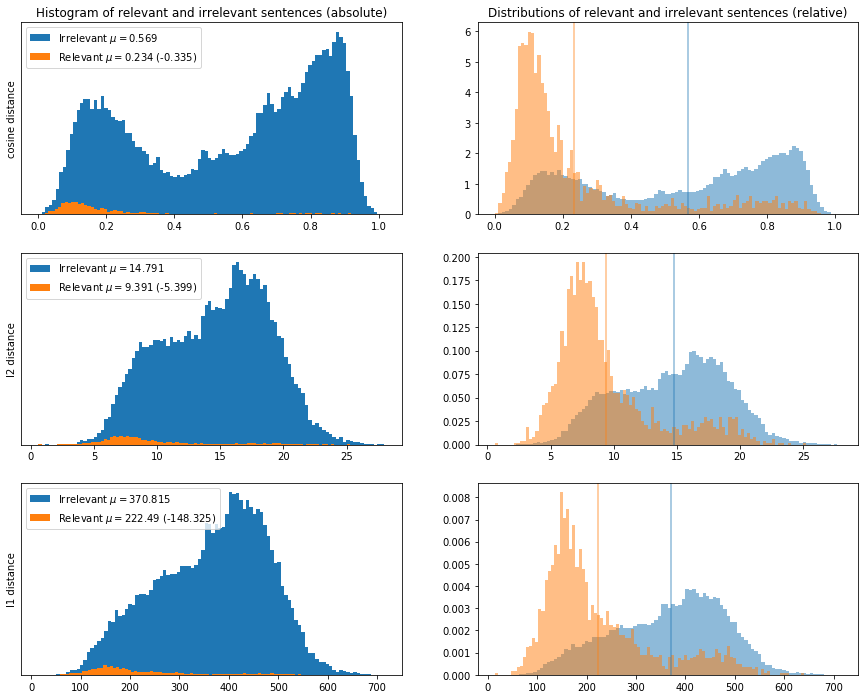

In [135]:
fig = plt.figure()
fig.set_size_inches(15, 12)
for k in range(1, len(dist_funcs) + 1):
    fig.add_subplot(len(dist_funcs), 2, (k * 2) - 1)
    res_nel = res_dists[k - 1][np.nonzero(np.asarray(Y) == 0)[0]]
    plt.hist(res_dists[k - 1], bins=100, label="Irrelevant $\mu = $" + str(round(np.mean(res_nel), 3)))
    res_rel = res_dists[k - 1][np.nonzero(np.asarray(Y) == 1)[0]]
    plt.hist(res_rel, bins=100, label="Relevant $\mu = $" + str(round(np.mean(res_rel), 3)) + \
             " (" + str(round(np.mean(res_rel) - np.mean(res_nel), 3)) + ")")
    if k == 1:
        plt.title("Histogram of relevant and irrelevant sentences (absolute)")
    plt.legend(loc="upper left")
    plt.yticks([])
    plt.ylabel(dist_funcs[k - 1][0].__name__)
    fig.add_subplot(len(dist_funcs), 2, k * 2)
    _, _, p = plt.hist(res_dists[k - 1], density=True, bins=100, alpha=0.5)
    plt.axvline(x=np.mean(res_nel), color=p[0].get_facecolor())
    res_rel = res_dists[k - 1][np.nonzero(np.asarray(Y) == 1)[0]]
    _, _, p = plt.hist(res_rel, density=True, bins=100, alpha=0.5)
    plt.axvline(x=np.mean(res_rel), color=p[0].get_facecolor())
    if k == 1:
        plt.title("Distributions of relevant and irrelevant sentences (relative)")
plt.show()

In [30]:
# save_ld((all_relsamples, Y, res, res_dists, idx_freqs, arg_min_idx, n_rel_missed), "rel_dists_0008")
all_relsamples, Y, res, res_dists, idx_freqs, arg_min_idx, n_rel_missed = load_ld("rel_dists_0008")

In [66]:
len(all_relsamples_)

125221

In [31]:
X, Y = res, np.asarray(Y).astype(int)
use_components = True
X = np.hstack([res_dists.T] + ([X.swapaxes(0, 1).reshape((X.shape[1], X.shape[0] * X.shape[2]))] if use_components else []))
ci = np.asarray([d[4] for d in all_relsamples])           # Claim indices for each sentence
ei = np.asarray([d[7] for d in all_relsamples])           # Evidence ids for each sentence
for i in range(len(claims)): claims[i]["claim_i"] = i
X.shape, Y.shape, ci.shape, ei.shape

((70445, 3075), (70445,), (70445,), (70445, 2))

In [32]:
# Store missed relevant samples
X_mr, Y_mr, ci_mr, ei_mr = X[-n_rel_missed:], Y[-n_rel_missed:], ci[-n_rel_missed:], ei[-n_rel_missed:]
X_, Y_, ci_, ei_ = X[:-n_rel_missed], Y[:-n_rel_missed], ci[:-n_rel_missed], ei[:-n_rel_missed]
X_mr.shape, X_.shape, ci_.shape, ei_.shape

((1047, 3075), (69398, 3075), (69398,), (69398, 2))

In [ ]:
# Generate new logistic regression model for given data subset (parameters described further below)
from sklearn.feature_selection import *
def new_model(X, Y, add_relmissed, X_mr, ci_mr, idx,
              C=None, usampl_ratio=None, proximity=None, pc_train=1.0):
    m = Pipeline(steps=[("scale", StandardScaler()),
#                         ("pca", PCA(n_components=220)),
                        ("select", SelectPercentile(f_classif, percentile=1)),
                        ("model", LogisticRegression(C=10.0 ** C, solver="liblinear"))])
    if add_relmissed:
        X_mr = X_mr[[i for i in range(len(X_mr)) if ci_mr[i] in idx]]
        X, Y = np.vstack([X, X_mr]), np.hstack([Y, np.ones(len(X_mr))])
    if proximity != -1:
        if usampl_ratio == -1: usampl_ratio = 1.0
        nel_idx, rel_idx = np.nonzero(Y == 0)[0], np.nonzero(Y == 1)[0]
        X_ = StandardScaler().fit_transform(X)
#         X_ = PCA(n_components=220).fit_transform(StandardScaler().fit_transform(X))
        nel_dists = [l2_distance(np.tile(X_[nel_idx[i]], (len(rel_idx), 1)), X_[rel_idx]) for i in range(len(nel_idx))]
        nel_dists = np.mean(nel_dists, axis=1)
        dist_ord = np.argsort(nel_dists)
        n_maj = round(len(rel_idx) * usampl_ratio)
        min_prox = n_maj / len(nel_idx)
        proximity = min(1.0, min_prox + (proximity * ((len(nel_idx) - n_maj) / len(nel_idx))))
        dist_ord = dist_ord[:max(n_maj, round(len(nel_idx) * proximity))]
        nel_i = dist_ord[::int(len(dist_ord) // n_maj)][:n_maj]
        train_idx = np.hstack([nel_idx[nel_i], rel_idx])
        X, Y = X[train_idx], Y[train_idx]
    if usampl_ratio != -1 and proximity == -1:
        nel_idx, rel_idx = np.nonzero(Y == 0)[0], np.nonzero(Y == 1)[0]
        n_maj = round(len(rel_idx) * usampl_ratio)
        np.random.shuffle(nel_idx)
        train_idx = np.hstack([nel_idx[:int(n_maj)], rel_idx])
        X, Y = X[train_idx], Y[train_idx]
    if pc_train != 1.0:  # If resizing, stratify the samples (so that our learning curve is smooth & representative)
        nel_idx, rel_idx = np.nonzero(Y == 0)[0], np.nonzero(Y == 1)[0]
        np.random.shuffle(nel_idx), np.random.shuffle(rel_idx)
        shuf_idx, rel_ratio, i = [], len(nel_idx) // len(rel_idx), -1
        for i in range(len(rel_idx)):
            shuf_idx += [nel_idx[i * rel_ratio:(i + 1) * rel_ratio], rel_idx[i:i + 1]]
        shuf_idx.append(nel_idx[(i + 1) * rel_ratio:])
        shuf_idx = np.hstack(shuf_idx)
        X, Y = X[shuf_idx], Y[shuf_idx]
        n_train = round(X.shape[0] * pc_train)
        X, Y = X[:n_train], Y[:n_train]
#     print(x.shape, Y.shape)
    m.fit(X, Y)
    return m, len(X)
# Define model training and validation set performance optimisation pipeline
def evaluate_params(train_idx, ci, ei, X_mr, ci_mr, cls, cv_k, pc_train,
      add_relmissed, proximity_undersampling, X, Y, sr,
                    C=None, proximity=None, usampl_ratio=None):
    trtr_inds, val_inds = gen_cv_inds(cv_k, len(train_idx))
    cv_probs, val_iidxs = [], []
    for cv_i in range(cv_k):
        trtr_idx, val_idx = trtr_inds[cv_i], val_inds[cv_i]
        trtr_idx, val_idx  = [train_idx[i] for i in trtr_idx], [train_idx[i] for i in val_idx]
        trtr_iidx, val_iidx = [i for i in range(len(X)) if ci[i] in trtr_idx], [i for i in range(len(X)) if ci[i] in val_idx]
        val_iidxs += val_iidx
        X_trtr_f, Y_trtr_f, ci_trtr_f = X[trtr_iidx], Y[trtr_iidx], ci[trtr_iidx]
        X_val_f, Y_val_f, ci_val_f = X[val_iidx], Y[val_iidx], ci[val_iidx]
        m, n_tr = new_model(X_trtr_f, Y_trtr_f, add_relmissed, X_mr, ci_mr, trtr_idx,
                    C=C, usampl_ratio=usampl_ratio, proximity=proximity, pc_train=pc_train)
        cv_probs.append(m.predict_proba(X_val_f)[:, 1])
    cv_probs = np.hstack(cv_probs)
#     scores_train = eval_rel(preds_train)
    scores = eval_rel(cv_probs, ci[val_iidxs], ei[val_iidxs], [cls[i] for i in train_idx], strict_rel=sr, verbose=False)
    return scores
# Define main function to evaluate and/or optimise relevance classification
def relevance_evaluation(
      optimise_C=True,
      balance_classes=True,       # In order of dependence; proximity undersampling requires class balancing to be enabled
      optimise_ratio=True,
      proximity_undersampling=False,
      optimise_proximity=True,
      C=0.5,
      usampl_ratio = 4.3,
      proximity=0.05,
      usampl_ratio_range=np.linspace(1, 10, 5),
    #   C_range=np.linspace(-2, 2, 17),
      C_range=np.linspace(-2, 2, 9),
#       C_range=np.linspace(-2, 2, 5),
#       C_range=np.asarray([0.5]),
      proximity_range=np.linspace(0, 1, 11),
      n_reps=3,                   # Number of times to run the outer cross validation
      cv_k=5,                     # Number of outer folds to test optimised model
      cv_k_internal=5,            # Number of internal folds to optimise hyperparameters for validation accuracy
      n_guess=32,                 # Number of uniformly random guesses at hyperparameters
      pc_train=1.0,               # Train with only a subset of the training data (for generating learning curve)
      add_relmissed=False,        # Whether to add the relevance samples missed by the retrieval to the training subset
      strict_rel=True,            # Whether to exclude negatively-classified sentences when less than 5 positive are found
      scoring_fn=0,               # Which score to maximise (0 = macro (Fever) F1)
      n_jobs=n_cpu,               # Multiprocessing number of parllel hyperparameter set evaluations
      pause=True,
      ):
    use_ = {"C": True, "proximity": proximity_undersampling, "usampl_ratio": balance_classes}
    hypopts = {"C": optimise_C, "proximity": proximity_undersampling and optimise_proximity,
               "usampl_ratio": balance_classes and optimise_ratio}
    hypopts_rs = {"C": C_range, "proximity": proximity_range, "usampl_ratio": usampl_ratio_range}
    n_hyperparams = sum(hypopts.values())
    r_hyp = range(n_hyperparams)
    hyp_ps = [key for key in hypopts if hypopts[key]]
    scores, top_pars, all_pars = [], [], []
    stop = False
    for run_i in range(n_reps):
        train_inds, test_inds = gen_cv_inds(cv_k, len(claims))  # Create testing cross validation indices to split claims set
        cv_probs, test_iidxs, top_par, all_par = [], [], [], []
        for cv_i in range(cv_k):
            gc.collect()
            sys_print("Run " + str(run_i + 1) + " Fold " + str(cv_i + 1) + '/' + str(cv_k) + '     ')
            train_idx, test_idx = train_inds[cv_i], test_inds[cv_i]
            train_iidx, test_iidx = [i for i in range(len(X_)) if ci_[i] in train_idx], \
                                    [i for i in range(len(X_)) if ci_[i] in test_idx]
            test_iidxs += test_iidx
            X_train_f, Y_train_f, ci_train_f = X_[train_iidx], Y_[train_iidx], ci_[train_iidx]
            X_test_f, Y_test_f, ci_test_f = X_[test_iidx], Y_[test_iidx], ci_[test_iidx]
            args = train_idx, ci_, ei_, X_mr, ci_mr, claims, cv_k_internal, pc_train, \
                add_relmissed, proximity_undersampling, X_, Y_, strict_rel
            ps = {"C": C, "proximity": proximity, "usampl_ratio": usampl_ratio}
            for key in ps:
                if not use_[key]: ps[key] = -1
#             pars = [dict([(hyp_ps[i], r[i]) for i in r_hyp]) for r in itertools.product(*[hypopts_rs[key] for key in hyp_ps])]
            pars = [dict([(hyp_ps[i], np.random.uniform(min(hypopts_rs[hyp_ps[i]]), \
                                                        max(hypopts_rs[hyp_ps[i]]))) for i in r_hyp]) for _ in range(n_guess)]
            opt_res = joblib.Parallel(n_jobs=n_jobs, verbose=2)(delayed(evaluate_params)(*args, **{**ps, **p}) for p in pars)
            opt_r = [r[0] for r in opt_res]
            max_i = np.argmax(opt_r)
            top_ps, opt_max = pars[max_i], opt_res[max_i]
            sys_print(str((opt_max[0], opt_max[1], opt_max[2], top_ps)) + '\n')
            top_par.append((opt_max, deepcopy(top_ps)))
            top_ps = {**ps, **top_ps}
            n_trtr = int(np.floor(len(train_idx) * (1.0 - (1.0 / cv_k_internal))))
            trtr_idx = [train_idx[i] for i in np.random.choice(range(len(train_idx)), n_trtr, replace=False)]
            trtr_iidx = [i for i in range(len(X_)) if ci_[i] in trtr_idx]
            X_trtr_f, Y_trtr_f, ci_trtr_f = X_[trtr_iidx], Y_[trtr_iidx], ci_[trtr_iidx]
            m, n_tr = new_model(X_trtr_f, Y_trtr_f, add_relmissed, X_mr, ci_mr, trtr_idx, pc_train=pc_train, **top_ps)
    #         preds_train = m.predict(X_train_f)  # todo
            probs_test = m.predict_proba(X_test_f)[:, 1]
            # preds_train = np.logical_and(preds_train, Xd_test[tau_dfunc].flatten() < tau).astype(int)
            # probs_test = np.logical_and(probs_test, Xd_test[tau_dfunc].flatten() < tau).astype(int)
            cv_probs.append(probs_test)
            all_par.append(list(zip(pars, deepcopy(opt_res))))
            if pause and input("Press any to continue") == "s":
                stop = True
                break
            stop = False
        top_pars.append(top_par)
        all_pars.append(all_par)
        if stop: break
        cv_probs = np.hstack(cv_probs)
    #     scores_train = eval_rel(preds_train)
        scores.append(eval_rel(cv_probs, ci_[test_iidxs], ei_[test_iidxs], claims, strict_rel=strict_rel, verbose=False))
    print(np.mean(scores))
    pr(top_pars)
    return scores, top_pars, all_pars
scores, top_pars, all_pars = relevance_evaluation()

In [24]:
save_ld((scores, top_pars, all_pars), "relevance_results_reldists_C+ratio+proximity")
# scores, top_pars, all_pars = load_ld("relevance_results")

In [34]:
scores, top_pars = load_ld("relevance_results_reldists_ratio")
scores

[[{'usampl_ratio': 4.0}]]

In [17]:
np.mean(scores, axis=0)

NameError: name 'scores' is not defined

In [ ]:
np.mean(sum([[t['C'] for t in tp] for tp in top_pars], []))

In [ ]:
top_pars

In [131]:
np.mean([s[0] for s in scores]), np.mean([s[4] for s in scores]), np.mean([s[8] for s in scores])

(0.2427248717630992, 0.4130693069306931, 0.17190429042904293)

In [129]:
np.mean([s[0] for s in scores]), np.mean([s[4] for s in scores]), np.mean([s[8] for s in scores])

(0.25805132823252663, 0.3817821782178218, 0.1949141914191419)

In [105]:
# Reduce unnecessary complexity by finding a threshold distance beyond which we can exclude the samples from training,
# as none of them are relevant, and are therefore unlikely to contribute information to the task of classifying relevant
# sentences at test time (add a small margin based on a fraction of the dataset size to account for the possibility)


In [24]:
i = np.nonzero(np.asarray(Y) == 1)[0][17]
# i = 455
idx_freqs[0][i], all_relsamples[i], res_dists[0, i], rel_data[all_relsamples[i][-2]]

NameError: name 'idx_freqs' is not defined

In [ ]:
# Try to seperate samples by the similarity measure alone (a 1D logistic regression)

In [34]:
from Models import *

In [64]:
m = LR(eta=1e-6, tol=1e-10, no_imp_stop=10, w_init='uniform', print_steps=10)
m.fit(X_train, Y_train)

|  iteration  |  accuracy  |  precision  |  recall  |  f1  |  f2  |
|  0  |  3453877.708596049  |  0.52237  |  0.0046645  |  0.5561097  |  0.0092514  |  0.0225654  |
|  10  |  3453877.7948727496  |  0.97199  |  0.0073892  |  0.0448878  |  0.0126895  |  0.0222772  |
Finished training (no loss improvement for 10 steps)


In [ ]:
# Draw learning curve (accuracy vs number of training datapoints)


In [91]:
x = np.asarray([[2,4],[-3,4],[5,3]])
y = np.array([1,2])
# np.sum(x * y, axis=1) / np.atleast_2d((np.sqrt(np.sum(x ** 2, axis=1)) * np.sqrt(np.sum(y ** 2))))
np.sum(x * y / np.atleast_2d((np.sqrt(np.sum(x ** 2, axis=1)) * np.sqrt(np.sum(y ** 2)))).T, axis=1)

array([1.        , 0.4472136 , 0.84366149])

In [37]:
# Figure out how long we should limit sentences to be when extracting embeddings (some outliers with len >1000 exist)
long_rel = 0
for i in range(len(rel_data)):
    for d_t in rel_data[i]["relevance_samples"]:
        for title, line, relevant in rel_data[i]["relevance_samples"][d_t]:
            if relevant and len(line.split(' ')) > 125:
                long_rel += 1
long_rel

0

In [51]:
claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '

In [64]:
# Retrieve top-5 similar documents using Laplace smoothing with Lidstone correction (using epsilon=0.05)
res = eval_model(lidstone_ll, epsilon=0.05, claims_=claims)
acc = res[0]
print(acc)
pr(res[1])

Computing similarities...
Batches: 540


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:  6.7min
[Parallel(n_jobs=96)]: Done 258 tasks      | elapsed: 11.6min
[Parallel(n_jobs=96)]: Done 458 out of 540 | elapsed: 17.8min remaining:  3.2min
[Parallel(n_jobs=96)]: Done 540 out of 540 | elapsed: 20.1min finished


Ranking documents...
Evaluating accuracy...
0.25666666666666665
[   [   (-88.32562602513612, 'Glossary_of_sumo_terms'),
        (-87.53034574001876, 'List_of_books_by_Jacob_Neusner'),
        (-87.09446736251365, 'List_of_video_game_crowdfunding_projects'),
        (-85.96664404030582, 'List_of_Latin_legal_terms'),
        (-85.88756594576691, 'List_of_songs_about_Paris')],
    [   (-113.69317923324901, 'Kanye_West_discography'),
        (-113.54722278740641, 'Outkast_discography'),
        (-110.87900565825775, 'Beyoncé_discography'),
        (-108.62218353065947, 'Ricky_Martin_singles_discography'),
        (-102.18636581560878, 'Snoop_Dogg_discography')],
    [   (-69.90791042003866, 'Alma_Ziegler'),
        (-69.85513001771425, 'Timeline_of_San_Bernardino,_California_history'),
        (-69.38033061091798, 'List_of_video_game_crowdfunding_projects'),
        (-68.90621816887726, 'Science_and_technology_in_Venezuela'),
        (-68.33329707121771, 'Wally_Donald')],
    [   (-97.3246

In [65]:
len(res[1])

100

In [132]:
similarities = [jm_ll(*wiki[doc_id]) for doc_id in D_ids]
print("Ranking documents...")
top_docs = []
for i in range(N_claims):
    sims = [(similarities[j][i], D_ids[j]) for j in range(N_docs)]
    sims.sort()
    top_docs.append(sims[-5:])
top_docs_ids = [[s[1] for s in s_] for s_ in top_docs]
print("Evaluating accuracy...")
recall = [np.mean([
    id_ in top_docs_ids[i] for id_ in set([s[2] for s in sum(claims[i]["evidence"], [])])]) \
                  for i in range(len(claims))]
np.mean(recall), top_docs

wat defaultdict(<class 'int'>, {'hunger': 0})


ZeroDivisionError: float division by zero

In [88]:
claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '

In [13]:
claim_ids = [75397, 150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]
claims = []
claims_vocab = set()
with open(data_dir + "train.jsonl", 'r') as f:
    a = jsonlines.Reader(f)
    for a_ in a:
        if a_["id"] in claim_ids:
            claims.append(a_)
            claims[-1]["vocab"] = defaultdict(int)
            for w in a_["claim"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", ''). \
              translate(punc_trans).lower().split():
                claims[-1]["vocab"][w] += 1
                claims_vocab.add(w)

In [15]:
N_docs = 0
n_t = defaultdict(int)
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            N_docs += 1
            entry = [[w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())]
            for w in set(sum(entry, [])):
                if w in claims_vocab:
                    n_t[w] += 1
    i_ += 1
    sys_print("\r" + str(i_))
N_docs

109

5416536

In [19]:
# Load each document and measure cosine similarity
similarities = {}
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            doc_tf = defaultdict(int)
            for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
                for w in l:
                    if w in claims_vocab:
                        doc_tf[w] += 1
            doc_tf = {w: doc_tf[w] * np.log(N_docs / n_t[w]) for w in doc_tf}
            similarities[a_["id"]] = [sum([doc_tf[w] for w in claim["vocab"] if w in doc_tf]) for claim in claims]
    i_ += 1
    sys_print("\r" + str(i_))
similarities = list(similarities.items())

109

In [22]:
top_docs = []
for i in range(10):
    sims = [(s[1][i], s[0]) for s in similarities]
    sims.sort()
    top_docs.append(sims[-5:])
top_docs

[[(566.179224990433, 'List_of_New_Jersey_street_railroads'),
  (579.0265022006889,
   'List_of_early_British_private_locomotive_manufacturers'),
  (580.2826817534418, 'List_of_OMIM_disorder_codes'),
  (920.8325654914589, 'Mottos_and_halls_of_the_Livery_Companies'),
  (1122.7571604226562, 'Pteropodinae')],
 [(236.04509710808153, 'History_of_the_Roman_Constitution'),
  (248.6656867489665, 'List_of_New_Zealand_religious_leaders'),
  (322.341723583277, 'List_of_New_Zealand_Catholic_bishops'),
  (331.034077391518, 'List_of_Catholic_schools_in_New_York'),
  (665.3830074019156, 'History_of_Rome_-LRB-disambiguation-RRB-')],
 [(943.9322647631498, 'Western_literature'),
  (1089.2646242221958, 'List_of_New_Music_America_performances'),
  (1261.5168052555575, 'List_of_national_theatres'),
  (1418.3355392869555, 'List_of_books_by_Jacob_Neusner'),
  (1574.613579602451,
   'List_of_artists_in_the_Philadelphia_Museum_of_Art_handbook_of_the_collections')],
 [(127.08135108472278, 'List_of_This_Is_Daniel

In [26]:
# Query-likelihood unigram language modelling (unsmoothed)
def prod(xs):
    if len(xs) == 0:
        return 0
    if len(xs) > 1:
        return xs[0] * prod(xs[1:])
    return xs[0]
likelihoods = {}
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            doc_M = defaultdict(int)
            total = 0
            for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
                for w in l:
                    if w in claims_vocab:
                        doc_M[w] += 1
                    total += 1
            doc_M = {w: doc_M[w] / total for w in doc_M}
            likelihoods[a_["id"]] = [prod([doc_M[w] for w in claim["vocab"] if w in doc_M]) for claim in claims]
    i_ += 1
    sys_print("\r" + str(i_))
likelihoods = list(likelihoods.items())

109

In [27]:
top_docs_us = []
for i in range(10):
    sims = [(s[1][i], s[0]) for s in likelihoods]
    sims.sort()
    top_docs_us.append(sims[-5:])
top_docs_us

[[(0.34615384615384615, 'The_Last_of_the_Jedi-COLON-_Against_the_Empire'),
  (0.35714285714285715, 'The_Glitterati_-LRB-album-RRB-'),
  (0.36363636363636365, 'The_Kabeedies_discography'),
  (0.375, 'On_air'),
  (0.38461538461538464, 'Public_holidays_in_the_Bahamas')],
 [(0.2857142857142857, 'List_of_fictional_alien_species-COLON-_A'),
  (0.3157894736842105, 'C30H50O4'),
  (0.3333333333333333, 'List_of_Members_of_the_Canadian_Senate_-LRB-A-RRB-'),
  (0.3333333333333333, 'Purpuric_acid'),
  (0.3333333333333333, 'Reem_-LRB-given_name-RRB-')],
 [(0.40625, 'Portuguese-language_literature'),
  (0.41935483870967744, 'East_Asian_poetry'),
  (0.42857142857142855, 'Arts_by_region'),
  (0.4523809523809524, 'Yugoslav_literature'),
  (0.5, 'Testament_of_Qahat')],
 [(0.25, 'Diosmetinidin'),
  (0.25, 'Ruether'),
  (0.2608695652173913, 'List_of_DC_Comics_characters-COLON-_K'),
  (0.3333333333333333, 'Purpuric_acid'),
  (0.3333333333333333, 'Reem_-LRB-given_name-RRB-')],
 [(0.373134328358209, 'Constitu

In [47]:
# Import wikipedia dataset document word counts for the claim vocabulary
wiki = {}
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            doc_M = defaultdict(int)
            total = 0
            for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
                for w in l:
                    if w in claims_vocab:
                        doc_M[w] += 1
                    total += 1
            wiki[a_["id"]] = doc_M, total
    i_ += 1
    sys_print("\r" + str(i_))
N_docs = len(wiki)
N_docs

5416536

In [49]:

top_docs_ls

[[(-93.88792155564518, 'Peter_Windsor'),
  (-93.3362426640573, 'Mike_Darnell'),
  (-93.2490523905636, "List_of_Bob's_Burgers_episodes"),
  (-93.14458474306068, 'Jimmy_Hodson'),
  (-92.12060364493253, 'Joel_Cheatwood')],
 [(-71.50651994917307, 'Ríos'),
  (-71.29546258204249, 'Giancarlo_Volpe'),
  (-70.35450291570794, 'List_of_essential_oils'),
  (-67.08361379838946, 'List_of_Latin_legal_terms'),
  (-64.71084161996984, 'List_of_video_game_crowdfunding_projects')],
 [(-212.1720252860265, 'List_of_New_Music_America_performances'),
  (-211.8780699805498, 'Narrative'),
  (-211.516743391354, 'List_of_Guggenheim_Fellowships_awarded_in_1968'),
  (-209.68037646198567, 'Acropolis_Institute_of_Technology_and_Research'),
  (-190.23549854041386, 'History_of_art')],
 [(-60.642762136163455, 'Loni_Love'),
  (-60.63228118073983, 'Jeannie_Mai'),
  (-60.41817178428785, 'Roy_"Royalty"_Hamilton'),
  (-60.251009380271654, 'Tamar_Braxton'),
  (-59.94750735936245, 'Adrienne_Bailon')],
 [(-169.6512907398757, 'L

0.75

In [31]:
claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '

In [ ]:
# Evaluate distances
arg_min_idx = 3    # Minimum index into the sentence to end truncation for minimising distance to query (experimental)
res = np.empty((len(dist_funcs), len(all_relsamples), 1024))
i_ = -1
idx_freqs = [[] for _ in range(len(dist_funcs))]
for j in range(n_elmo_bats):
    rel_bat = all_relsamples[j * elmo_bsize:(j + 1) * elmo_bsize]
    elmo_samples = load_ld("H:\Code\IR\data\learning_data\elmo_res_" + str(j) + ".data", pad=False)
#     pr(elmo_samples[0])
#     break
    for i in range(elmo_samples.shape[0]):
        i_ += 1
#         print(rel_data[rel_bat[i][4]]["claim"])
#         print(rel_bat[i][1])
        query_elmo = query_elmos[rel_bat[i][4]]
        elmo_sample = elmo_samples[i]
        elmo_comps = [eval_comps(elmo_sample, f, query_elmo) for (_, f) in dist_funcs]
        elmo_dists = [eval_dists(elmo_comps[k], dist_funcs[k][0]) for k in range(len(dist_funcs))]
        n_words = rel_bat[i][5]
        title_len = len(rel_bat[i][0].split(' '))
        min_idx = max(min(title_len + arg_min_idx + 1, n_words - 2), 0)
        for k in range(len(dist_funcs)):
#             print(elmo_dists[k].round(3))
#             print((n_words - 1,
#                     max(title_len + arg_min_idx + 1, 
#                     np.argmin(elmo_dists[k]))))
#             if min_idx >= n_words - 1:
#                 print(rel_data[rel_bat[i][4]]["claim"])
#                 print(rel_bat[i][0], rel_bat[i][1])
#                 print(elmo_dists[k])
#                 print(min_idx, n_words - 1)
#             try:
            idx = min_idx + np.argmin(elmo_dists[k][min_idx:max(n_words - 1, 1)])
#             except:
#                 print(rel_data[rel_bat[i][4]]["claim"])
#                 print(rel_bat[i][0], ' : ', rel_bat[i][1])
#                 print(elmo_dists[k])
#                 print(min_idx, n_words - 1)
#                 print("Unexpected error:", sys.exc_info()[0])
#                 raise
#             print(idx, elmo_dists[k][idx])
#             print(n_words - 1 == idx)
            idx_freqs[k].append((n_words, idx))
#             if not n_words - 1 == idx:
#             if True:
#                 print(rel_data[rel_bat[i][4]]["claim"])
#                 print(rel_bat[i][1])
#                 print(elmo_dists[k])
#                 print(idx, elmo_dists[k][idx])
#                 print(np.argmin(elmo_dists[k]), elmo_dists[k][np.argmin(elmo_dists[k])])
#                 print(elmo_dists[k][idx])
#                 print(elmo_comps[k][idx])
#                 print(sum(elmo_comps[k][idx]))
#                 sys.exit()
            res[k, i_] = elmo_comps[k][idx]
    del elmo_samples
    gc.collect()
    sys_print("\rBatch " + str(j + 1) + '/' + str(n_elmo_bats) + '     ')

In [167]:
query_incl_fstop = True   # Whether to include the fullstop at the end of the claim
query_use_mean = False          # Whether to use the mean of the words rather than the last word
query_model = True      # Whether to weight words according to probability of occuring in the specific query
def rem_fullstop(x):
    return x[:-1].strip() if x[-1] == '.' and not query_incl_fstop else x
query_elmos = []
n_batches = 8
for i in range(n_batches):
    i_, i__ = i * (len(rel_data) // n_batches), ((i + 1) * (len(rel_data) // n_batches)) if i < n_batches - 1 else len(rel_data)
    ix = [len(rem_fullstop(claim["relevance_claim"]).split(' ')) - (0 if query_use_mean else 1) for claim in rel_data[i_:i__]]
    xs = elmo_vectors([rem_fullstop(claim["relevance_claim"]) for claim in rel_data[i_:i__]])
    query_elmos += [np.vstack([np.mean(xs[j, :ix[j]], axis=0) for j in range(len(xs))]) if query_use_mean else \
                    xs[range(len(xs)), ix]]
    sys_print("\r" + str(i + 1) + '/' + str(n_batches))
query_elmos = np.vstack(query_elmos)

8/8